In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.loss import *
from tomopt.volume import *
from tomopt.core import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

# Opt 

In [7]:
volume = Volume(get_layers())
dets = volume.get_detectors()
opt = torch.optim.SGD(volume.parameters(), lr=2e-3)
mu = MuonBatch(generate_batch(1000), init_z=1)
volume(mu)
scatters = ScatterBatch(mu, volume)
inferer = X0Inferer(scatters)
pred, weight = inferer.pred_x0()
loss_func = DetectorLoss(1)
loss_val = loss_func(pred, weight, inferer.volume)

X0 comp: 7064.16, cost comp: 41393


In [27]:
torch.optim.SGD(volume.parameters(), lr=2e-8)
opt.zero_grad()
dets = volume.get_detectors()

In [28]:
loss_val.backward()

In [9]:
for i in range(4):
    print(i, dets[i].resolution.grad, dets[i].efficiency.grad) 

0 tensor([[ 0.2019,  0.1988,  0.1985, -0.0337,  0.1049,  0.1825, -0.6029, -0.0251,
          0.1410,  0.1994],
        [ 0.1155,  0.1602,  0.1748,  0.1771,  0.0589,  0.2000,  0.1445,  0.0751,
          0.1185,  0.2002],
        [ 0.1633,  0.1977,  0.1818,  0.1638, -0.0565,  0.1123,  0.0510, -0.4711,
          0.1693,  0.0806],
        [ 0.1063,  0.1937,  0.1217,  0.1826,  0.1275,  0.1106,  0.0811,  0.1403,
         -0.1640, -0.2790],
        [ 0.1512,  0.0389,  0.1092, -0.0461,  0.1623,  0.1375,  0.0775,  0.1675,
         -0.1400,  0.1042],
        [ 0.1934,  0.1859,  0.0562,  0.1102, -0.3446, -0.2543,  0.0415, -0.0685,
         -0.0184,  0.1983],
        [ 0.1401, -0.1586,  0.1933, -0.1749,  0.1918,  0.1798,  0.0850,  0.1941,
          0.1485,  0.1786],
        [ 0.1624,  0.1592,  0.1857,  0.1820,  0.0228,  0.0706, -0.0333, -0.0052,
         -0.0445,  0.1931],
        [ 0.1949,  0.1484,  0.1621, -0.0413,  0.1539,  0.1953,  0.1961,  0.1793,
         -0.0096,  0.1969],
        [ 0.1974,

In [10]:
for l in volume.get_detectors():  torch.nan_to_num_(l.resolution.grad, 0)

In [11]:
for i in range(4):
    print(i, dets[i].resolution.grad, dets[i].efficiency.grad) 

0 tensor([[ 0.2019,  0.1988,  0.1985, -0.0337,  0.1049,  0.1825, -0.6029, -0.0251,
          0.1410,  0.1994],
        [ 0.1155,  0.1602,  0.1748,  0.1771,  0.0589,  0.2000,  0.1445,  0.0751,
          0.1185,  0.2002],
        [ 0.1633,  0.1977,  0.1818,  0.1638, -0.0565,  0.1123,  0.0510, -0.4711,
          0.1693,  0.0806],
        [ 0.1063,  0.1937,  0.1217,  0.1826,  0.1275,  0.1106,  0.0811,  0.1403,
         -0.1640, -0.2790],
        [ 0.1512,  0.0389,  0.1092, -0.0461,  0.1623,  0.1375,  0.0775,  0.1675,
         -0.1400,  0.1042],
        [ 0.1934,  0.1859,  0.0562,  0.1102, -0.3446, -0.2543,  0.0415, -0.0685,
         -0.0184,  0.1983],
        [ 0.1401, -0.1586,  0.1933, -0.1749,  0.1918,  0.1798,  0.0850,  0.1941,
          0.1485,  0.1786],
        [ 0.1624,  0.1592,  0.1857,  0.1820,  0.0228,  0.0706, -0.0333, -0.0052,
         -0.0445,  0.1931],
        [ 0.1949,  0.1484,  0.1621, -0.0413,  0.1539,  0.1953,  0.1961,  0.1793,
         -0.0096,  0.1969],
        [ 0.1974,

In [12]:
opt.step()

In [14]:
for i in range(4):
    print(i, dets[i].resolution.sum(), dets[i].efficiency.sum()) 

0 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
1 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
2 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
3 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)


In [50]:
volume = Volume(get_layers())
opt = torch.optim.SGD([{'params':(l.resolution for l in volume.get_detectors()), 'lr':2e1},
                       {'params':(l.efficiency for l in volume.get_detectors()), 'lr':2e-5}])
loss_func = DetectorLoss(0.15)
loss_hist = []
for i in range(100):
    mu = MuonBatch(generate_batch(1000), init_z=1)
    volume(mu)
    scatters = ScatterBatch(mu, volume)
    inferer = X0Inferer(scatters)
    pred, weight = inferer.pred_x0()
    loss_val = loss_func(pred, weight, inferer.volume)
    loss_hist.append(loss_val.data.item())
    print(i, loss_hist[-1])
    opt.zero_grad()
    loss_val.backward()
    for l in volume.get_detectors():
        torch.nan_to_num_(l.resolution.grad, 0)
        torch.nan_to_num_(l.efficiency.grad, 0)
    opt.step()
    for j,l in enumerate(volume.get_detectors()):
        print(j, l.resolution.mean(), l.efficiency.mean()) 

X0 comp: 5522.39, cost comp: 6209
0 11731.2958984375
0 tensor(1001.4551, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
1 tensor(1001.5225, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
2 tensor(1001.3736, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
3 tensor(1001.3372, grad_fn=<MeanBackward0>) tensor(0.4978, grad_fn=<MeanBackward0>)
X0 comp: 7238.51, cost comp: 6224
1 13462.7265625
0 tensor(1003.2394, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
1 tensor(1003.0482, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
2 tensor(1003.1008, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
3 tensor(1003.6011, grad_fn=<MeanBackward0>) tensor(0.4948, grad_fn=<MeanBackward0>)
X0 comp: 5979.94, cost comp: 6244
2 12223.99609375
0 tensor(1004.9886, grad_fn=<MeanBackward0>) tensor(0.4923, grad_fn=<MeanBackward0>)
1 tensor(1004.6322, grad_fn=<MeanBackward0>) tensor(0.4923, grad_fn=<MeanBackward

X0 comp: 3490.11, cost comp: 6481
21 9971.48828125
0 tensor(1026.0687, grad_fn=<MeanBackward0>) tensor(0.4501, grad_fn=<MeanBackward0>)
1 tensor(1025.9722, grad_fn=<MeanBackward0>) tensor(0.4501, grad_fn=<MeanBackward0>)
2 tensor(1025.5743, grad_fn=<MeanBackward0>) tensor(0.4502, grad_fn=<MeanBackward0>)
3 tensor(1025.7686, grad_fn=<MeanBackward0>) tensor(0.4502, grad_fn=<MeanBackward0>)
X0 comp: 2853.88, cost comp: 6488
22 9341.44140625
0 tensor(1026.4570, grad_fn=<MeanBackward0>) tensor(0.4488, grad_fn=<MeanBackward0>)
1 tensor(1026.3911, grad_fn=<MeanBackward0>) tensor(0.4487, grad_fn=<MeanBackward0>)
2 tensor(1025.8483, grad_fn=<MeanBackward0>) tensor(0.4489, grad_fn=<MeanBackward0>)
3 tensor(1026.1801, grad_fn=<MeanBackward0>) tensor(0.4489, grad_fn=<MeanBackward0>)
X0 comp: 3556.64, cost comp: 6491
23 10047.904296875
0 tensor(1027.2484, grad_fn=<MeanBackward0>) tensor(0.4471, grad_fn=<MeanBackward0>)
1 tensor(1026.9337, grad_fn=<MeanBackward0>) tensor(0.4471, grad_fn=<MeanBackwar

X0 comp: 3056.69, cost comp: 6583
42 9639.3759765625
0 tensor(1036.8391, grad_fn=<MeanBackward0>) tensor(0.4186, grad_fn=<MeanBackward0>)
1 tensor(1035.3621, grad_fn=<MeanBackward0>) tensor(0.4185, grad_fn=<MeanBackward0>)
2 tensor(1034.4940, grad_fn=<MeanBackward0>) tensor(0.4188, grad_fn=<MeanBackward0>)
3 tensor(1035.3530, grad_fn=<MeanBackward0>) tensor(0.4188, grad_fn=<MeanBackward0>)
X0 comp: 2689.57, cost comp: 6587
43 9276.3984375
0 tensor(1037.1382, grad_fn=<MeanBackward0>) tensor(0.4173, grad_fn=<MeanBackward0>)
1 tensor(1035.7421, grad_fn=<MeanBackward0>) tensor(0.4172, grad_fn=<MeanBackward0>)
2 tensor(1034.6815, grad_fn=<MeanBackward0>) tensor(0.4174, grad_fn=<MeanBackward0>)
3 tensor(1035.7666, grad_fn=<MeanBackward0>) tensor(0.4175, grad_fn=<MeanBackward0>)
X0 comp: 1966.76, cost comp: 6590
44 8556.74609375
0 tensor(1037.1616, grad_fn=<MeanBackward0>) tensor(0.4163, grad_fn=<MeanBackward0>)
1 tensor(1035.7836, grad_fn=<MeanBackward0>) tensor(0.4162, grad_fn=<MeanBackward

X0 comp: 1835.09, cost comp: 6619
63 8454.162109375
0 tensor(1040.6245, grad_fn=<MeanBackward0>) tensor(0.3934, grad_fn=<MeanBackward0>)
1 tensor(1039.1079, grad_fn=<MeanBackward0>) tensor(0.3932, grad_fn=<MeanBackward0>)
2 tensor(1038.2653, grad_fn=<MeanBackward0>) tensor(0.3934, grad_fn=<MeanBackward0>)
3 tensor(1039.1106, grad_fn=<MeanBackward0>) tensor(0.3935, grad_fn=<MeanBackward0>)
X0 comp: 1900.44, cost comp: 6619
64 8519.0703125
0 tensor(1040.6548, grad_fn=<MeanBackward0>) tensor(0.3924, grad_fn=<MeanBackward0>)
1 tensor(1039.1243, grad_fn=<MeanBackward0>) tensor(0.3922, grad_fn=<MeanBackward0>)
2 tensor(1038.2792, grad_fn=<MeanBackward0>) tensor(0.3923, grad_fn=<MeanBackward0>)
3 tensor(1039.1060, grad_fn=<MeanBackward0>) tensor(0.3925, grad_fn=<MeanBackward0>)
X0 comp: 1962.61, cost comp: 6618
65 8580.8408203125
0 tensor(1040.6647, grad_fn=<MeanBackward0>) tensor(0.3913, grad_fn=<MeanBackward0>)
1 tensor(1039.2692, grad_fn=<MeanBackward0>) tensor(0.3912, grad_fn=<MeanBackwar

X0 comp: 1870.58, cost comp: 6613
84 8483.2578125
0 tensor(1041.2850, grad_fn=<MeanBackward0>) tensor(0.3719, grad_fn=<MeanBackward0>)
1 tensor(1039.8401, grad_fn=<MeanBackward0>) tensor(0.3717, grad_fn=<MeanBackward0>)
2 tensor(1038.7030, grad_fn=<MeanBackward0>) tensor(0.3718, grad_fn=<MeanBackward0>)
3 tensor(1039.2640, grad_fn=<MeanBackward0>) tensor(0.3720, grad_fn=<MeanBackward0>)
X0 comp: 1739.20, cost comp: 6613
85 8351.8125
0 tensor(1041.3129, grad_fn=<MeanBackward0>) tensor(0.3709, grad_fn=<MeanBackward0>)
1 tensor(1039.7638, grad_fn=<MeanBackward0>) tensor(0.3707, grad_fn=<MeanBackward0>)
2 tensor(1038.5945, grad_fn=<MeanBackward0>) tensor(0.3709, grad_fn=<MeanBackward0>)
3 tensor(1039.2249, grad_fn=<MeanBackward0>) tensor(0.3710, grad_fn=<MeanBackward0>)
X0 comp: 1763.68, cost comp: 6611
86 8375.1357421875
0 tensor(1041.3296, grad_fn=<MeanBackward0>) tensor(0.3699, grad_fn=<MeanBackward0>)
1 tensor(1039.7240, grad_fn=<MeanBackward0>) tensor(0.3697, grad_fn=<MeanBackward0>)


In [51]:
dets = volume.get_detectors()

In [52]:
for i in range(4):
    print(i, dets[i].resolution)

0 Parameter containing:
tensor([[ 994.2247, 1013.0966, 1029.6165, 1026.1383, 1023.9159, 1018.0795,
         1015.3277, 1019.5292, 1021.8450, 1011.8549],
        [1026.5762, 1054.0619, 1052.8595, 1034.2419, 1073.9166, 1046.2886,
         1033.0154, 1037.9781, 1024.5985, 1026.8549],
        [1047.6365, 1052.3031, 1063.3032, 1024.9244, 1029.0962, 1035.8312,
         1060.2318, 1046.5743, 1046.1669, 1015.3944],
        [1016.7523, 1045.1207, 1042.8156, 1039.8953, 1035.9182, 1031.1001,
         1044.4204, 1043.4393, 1038.8167, 1015.1533],
        [1015.8055, 1039.7281, 1044.8513, 1052.9072, 1057.6749, 1046.7905,
         1063.3385, 1043.9358, 1036.7417, 1020.5594],
        [1042.0054, 1060.5137, 1047.7462, 1047.3372, 1057.6572, 1054.0243,
         1046.9061, 1060.9224, 1062.2491, 1044.4874],
        [1026.8682, 1050.2417, 1048.2688, 1048.9501, 1049.2894, 1048.8344,
         1091.0558, 1050.5278, 1053.9347, 1038.3114],
        [1027.5571, 1042.4779, 1042.2351, 1038.4543, 1049.0175, 1052.6833

In [53]:
for i in range(4):
    print(i, dets[i].efficiency) 

0 Parameter containing:
tensor([[0.4377, 0.4100, 0.3870, 0.3939, 0.4040, 0.4062, 0.4014, 0.3949, 0.4032,
         0.4162],
        [0.3878, 0.3672, 0.3594, 0.3672, 0.3317, 0.3742, 0.3647, 0.3786, 0.3808,
         0.4010],
        [0.3750, 0.3609, 0.3389, 0.3886, 0.3859, 0.3814, 0.3373, 0.3630, 0.3632,
         0.4103],
        [0.4089, 0.3699, 0.3687, 0.3736, 0.3708, 0.3796, 0.3626, 0.3745, 0.3617,
         0.4070],
        [0.3976, 0.3834, 0.3504, 0.3611, 0.3494, 0.3542, 0.3341, 0.3495, 0.3703,
         0.3975],
        [0.3874, 0.3537, 0.3494, 0.3490, 0.3361, 0.3275, 0.2972, 0.3076, 0.2998,
         0.3117],
        [0.3866, 0.3741, 0.3723, 0.3602, 0.3345, 0.2797, 0.2003, 0.2770, 0.2740,
         0.3332],
        [0.3788, 0.3644, 0.3779, 0.3552, 0.3483, 0.3071, 0.3146, 0.2843, 0.3285,
         0.3129],
        [0.4134, 0.3765, 0.3825, 0.3714, 0.3593, 0.3197, 0.2761, 0.2977, 0.3132,
         0.3414],
        [0.4290, 0.3896, 0.3976, 0.3893, 0.3856, 0.3857, 0.3478, 0.3242, 0.3080,
    

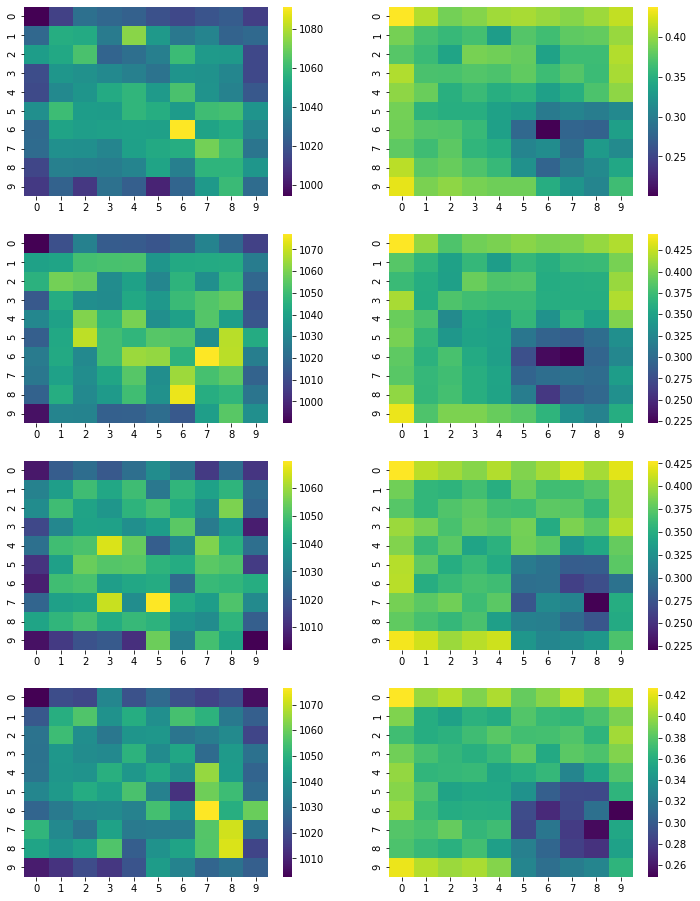

In [71]:
fig,axs = plt.subplots(4,2, figsize=(12,16))
for i,l in enumerate(dets):
    sns.heatmap(l.resolution.data.cpu().numpy(),ax=axs[i][0], cmap='viridis')
    sns.heatmap(l.efficiency.data.cpu().numpy(),ax=axs[i][1], cmap='viridis')    

In [58]:
mu = MuonBatch(generate_batch(10000), init_z=1)
volume(mu)
sb = ScatterBatch(mu, volume)

In [67]:
inferer = X0Inferer(sb, default_pred=None)
pred, weight = inferer.pred_x0()

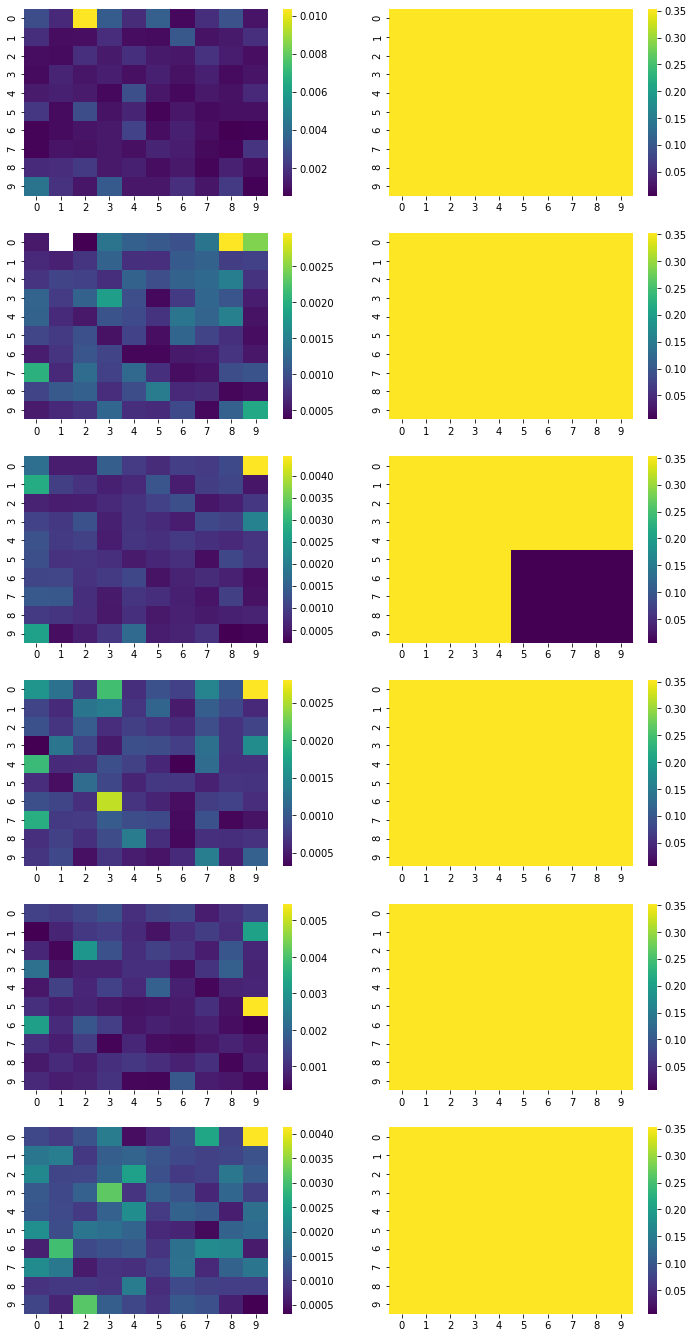

In [76]:
n = len(volume.get_passives())
fig,axs = plt.subplots(n,2, figsize=(12,24))
true = volume.get_rad_cube()

pred.min()

for i in range(n):
    sns.heatmap(pred[i].data.cpu().numpy(),ax=axs[i][0], cmap='viridis')
    sns.heatmap(true[i].data.cpu().numpy(),ax=axs[i][1], cmap='viridis', vmin=true.min(), vmax=true.max())    

In [62]:
sb.location.shape

torch.Size([8439, 3])